# Simulation of a noisy 16-QAM

In this tutorial, we cover the following concept :
* `sequence` of modules

At the end of this tutorial, you should be able to :
* Create a `sequence` of modules
* Create and bind a monitor module to compute the error rate
* Write a simple simulation loop
* Plot the resulting BER/FER

<a id='com_chain'></a>
![16QAM_sequence](https://aff3ct.github.io/images/doc_py_aff3ct/16QAM_chain.svg)

## Import libraries

In this tutorial, in addition to `py_aff3ct` library, we need the `numpy` and the `matplotlib` libraries. You can install these libraries with `pip` as follow on Ubuntu 20.04:
```bash
$ sudo apt install python3-pip
$ pip3 install --user -r requirements.txt
```

In [1]:
import sys  
sys.path.insert(0, '../../build/lib')

import py_aff3ct

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%qtconsole

## Build the `modules`
We start by building all the necessary objects for our simulation:
* a `Source_random` for generating the bits
* a `Encoder_repetition_sys` to encode the message, here using a repetition code
* a `Modem_generic` to modulate/demodulate the bits as 16-QAM symbols
* a `Channel_AWGN_LLR` to add a White Gaussian Noise (AWGN channel)
* a `Decoder_NO` to decide the demodulation output to recover the bits
* a `Monitor_BFER_AR` to count the number of errors and compute the Binary Error Rate (BER) and Frame Error Rate (FER) and perform Automatic Reduction (for enabling multi-threaded simulations)

In [3]:
K   = 2048   # Message size in bits
N   = 4096   # Packet length in bits
bps = 4      # Bits per Symbols   
Ns  = N//bps # Packet size in symbols

src  = py_aff3ct.module.source.Source_random           (K      ) # Build source
enc  = py_aff3ct.module.encoder.Encoder_repetition_sys (K,N    ) # Build the encoder
cstl = py_aff3ct.tools.constellation.Constellation_QAM (bps    ) # Setup constellation tool
mdm  = py_aff3ct.module.modem.Modem_generic            (N, cstl) # Build the modem
chn  = py_aff3ct.module.channel.Channel_AWGN_LLR       (2*Ns   ) # Build the channel (Ns complex symbols = 2Ns real dims)
dec  = py_aff3ct.module.decoder.Decoder_repetition_std (K,N    ) # Build the decoder
mnt  = py_aff3ct.module.monitor.Monitor_BFER_AR        (K,100  ) # Build the monitor (counting errors)

## Bind and execute the `tasks`
Now we can bind the different tasks in order to create the processing sequence described in [this picture](#com_chain).

In [4]:
enc[      'encode::U_K' ] = src[   'generate::U_K' ] # Source       -> Encoder
mdm[    'modulate::X_N1'] = enc[     'encode::X_N' ] # Encoder      -> Modulation
chn[   'add_noise::X_N' ] = mdm[   'modulate::X_N2'] # Modulation   -> Channel
mdm[  'demodulate::Y_N1'] = chn[  'add_noise::Y_N' ] # Channel      -> Demodulation
dec[ 'decode_siho::Y_N' ] = mdm[ 'demodulate::Y_N2'] # Demodulation -> Decoder
mnt['check_errors::U'   ] = src[   'generate::U_K' ] # Source       -> Monitor
mnt['check_errors::V'   ] = dec['decode_siho::V_K' ] # Decoder      -> Monitor

<a id='sigma_def'></a>
If you look at the information for tasks `add_noise` and `demodulate`, you will found out that a socket named `CP` should be filled. `CP` stands for "Channel Parameter", which for Additive White Gaussian Noise (AWGN) channel, represents the noise standard deviation. Let now fill this socket with a user defined value. 

In [5]:
sigma = np.ndarray(shape = (1,1),  dtype = np.float32)
sigma[0] = 0.05

chn[ 'add_noise::CP'].bind(sigma)
mdm['demodulate::CP'].bind(sigma)
print("Channel Parameter (CP) for 'chn':", chn[ 'add_noise::CP'][:])
print("Channel Parameter (CP) for 'mdm':", mdm['demodulate::CP'][:])

Channel Parameter (CP) for 'chn': [[0.05]]
Channel Parameter (CP) for 'mdm': [[0.05]]


In [6]:
src['generate'   ].exec()
enc['encode'     ].exec()
mdm['modulate'   ].exec()
chn['add_noise'  ].exec()
mdm['demodulate' ].exec()
dec['decode_siho'].exec()

## Display data
As in the Hello World tutorial, we can recover `socket` data and then display its constellation diagram using `matplotlib`.

In [7]:
sent_signal = mdm[  'modulate::X_N2'][:]
recv_signal = mdm['demodulate::Y_N1'][:]

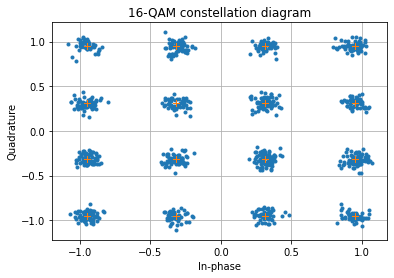

In [8]:
plt.plot(recv_signal[0, ::2], recv_signal[0, 1::2], '.')
plt.plot(sent_signal[0, ::2], sent_signal[0, 1::2], '+')
plt.title("16-QAM constellation diagram")
plt.xlabel("In-phase")
plt.ylabel("Quadrature")
plt.grid()

In [9]:
mnt['check_errors'].debug = True
mnt['check_errors'].set_debug_limit(8)
mnt['check_errors'].exec()
mnt['check_errors'].debug = False

# Monitor_BFER_AR::check_errors(const int32 U[2048], const int32 V[2048])
# {IN}  U = [    1,     1,     1,     1,     1,     1,     1,     1, ...]
# {IN}  V = [    1,     1,     1,     1,     1,     1,     1,     1, ...]
# Returned status: [0 'SUCCESS']
#


Changing the value of `sigma` [here](#sigma2_def) and re-executing the following cells should change the returned status of the `Monitor_BFER` module.